# Performance

Here we explore the performance of some aspects of the code.

## Current Summary

Currently, using IPyWidgets with an appropriate Image widget is fast enough for interactive displaying, but there are some issues:

**Issues**
* Decent performance can be realized with the JPEG format, but this does not support alpha channels like PNG.  PNG is significantly slower.
* The Image widget is [currently broken on CoLaboratory](https://github.com/googlecolab/colabtools/issues/587).
* There is no way to click or drag on the Image widget, so we are stuck with sliders etc.

**Options**
* [Jupyter Canvas Widget](https://github.com/Who8MyLunch/Jupyter_Canvas_Widget)

# Display

The main visual element of the program is the rapid update of an image from the server.  Here we explore some options for updating in a notebook to see what performance we can get.  For demonstration purposes we update a random frame.

In [ ]:
import threading
import time
def run():
    n = 1
    while True:
        print(n)
        time.sleep(1)
        n += 1
t = threading.Thread(target=run)
t.start()

In [ ]:
t.join()

In [2]:
%%javascript

IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

In [3]:
import io
import time
from PIL import Image
import numpy as np
from matplotlib import cm
Nxy = (1280, 720)  # 720p resolution
#Nxy = (512, 512)

def get_data(t=None, Nxy=Nxy, t_=[0.0], dt=0.1):
    Nx, Ny = Nxy
    if t is None:
        t_[0] += dt
        t = t_[0]
    x = np.linspace(-2,2,Nx)[:, None]
    y = np.linspace(-2,2,Ny)[None, :]
    n = np.exp(-x**2 - np.cos(np.log(1+t)*x)**2*(y**2 - np.sin(3*t)*x)**2)
    return n
    #data = cm.viridis(n, bytes=True)
    #psi = np.random.random(Nxy + (2,)).view(dtype=complex).reshape(Nxy)-0.5-0.5j
    #n = abs(psi)**2
    return n/n.max()

def data_to_rgba(data):
    """Convert the data to RGBA data"""
    return cm.viridis(data.T, bytes=True)

def rgba_to_png(rgba, size=None):
    b = io.BytesIO()
    img = Image.fromarray(rgba)
    if size is not None:
        img = img.resize(size)
    img.save(b, 'PNG')
    return b.getvalue()
    
def rgba_to_jpeg(rgba, size=None):
    """JPEG formatter, but discards alpha"""
    b = io.BytesIO()
    img = Image.fromarray(rgba[..., :3])
    if size is not None:
        img = img.resize(size)
    img.save(b, 'JPEG')
    return b.getvalue()

def fps(f, N=10):
    tic = time.time()
    for n in range(N):
        f()
    toc = time.time()
    fps = N/(toc-tic)
    print(f"{fps:.1f}fps")
    return fps

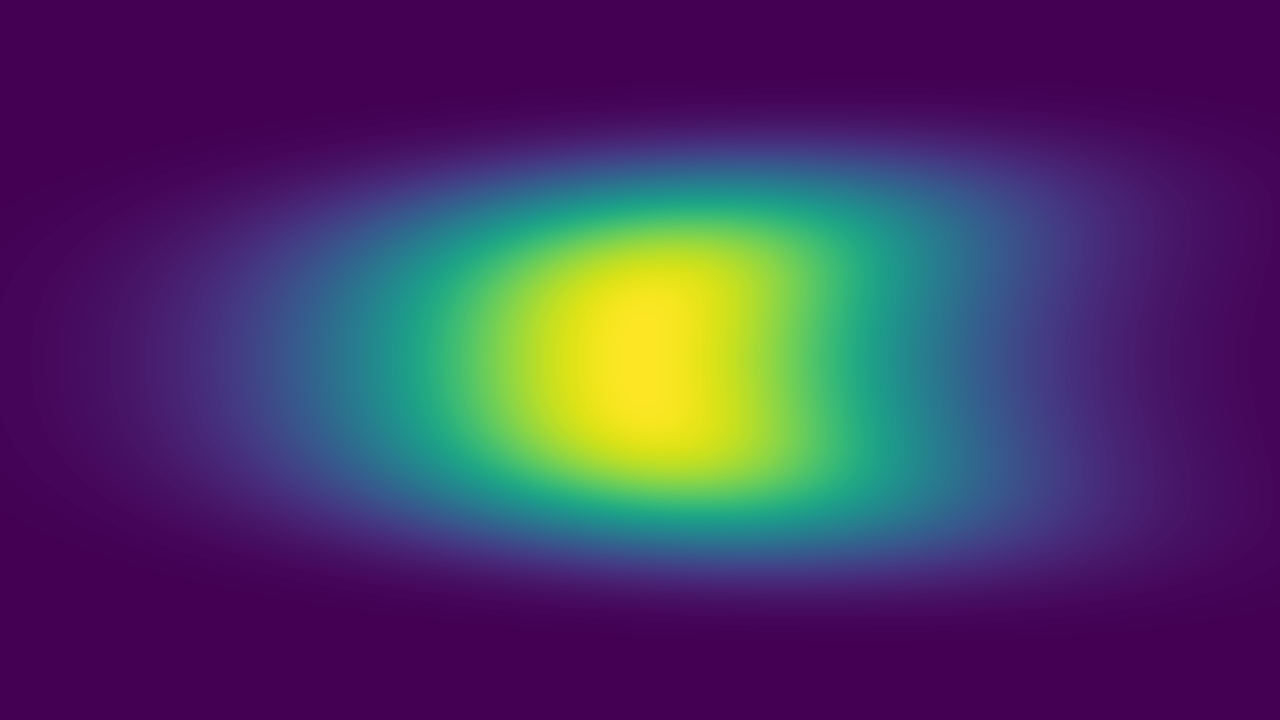

data: 34.5fps
rgba: 21.6fps
png: 7.1fps
jpeg: 12.4fps
Image: 21.6fps


In [3]:
display(Image.fromarray(data_to_rgba(get_data())))

print("data: ", end='');fps(lambda: get_data());
print("rgba: ", end='');fps(lambda: data_to_rgba(get_data()));
print("png: ", end='');fps(lambda: rgba_to_png(data_to_rgba(get_data())));
print("jpeg: ", end='');fps(lambda: rgba_to_jpeg(data_to_rgba(get_data())));
print("Image: ", end='');fps(lambda: Image.fromarray(data_to_rgba(get_data())));

On my computer, generating random data at this resolution and converting it to an array for display is fast enough to get ~20fps.  Converting to an image with PNG is prohibatively slow, but JPEG is margina.  Now we look into displaying this.

## HTML5 Canvas

Here is our custom HTML5 Canvas widget.  It is currently fast enough, though performance could probably be improved (at least with modern browsers that support ImageBitmaps).

In [4]:
import mmf_setup.set_path.hgroot
import ipywidgets as widgets
from ipywidgets import Label, VBox, IntSlider
from importlib import reload
from super_hydro.client import canvas_widget;reload(canvas_widget)
from super_hydro.contexts import NoInterrupt
canvas_widget.display_js()   # Load javascript
canvas = canvas_widget.Canvas()
canvas.width = 500
canvas.height = 0
canvas.tracer_size = "1"
proxy = 1

canvas.fg_object = {
    "tracer": [["tracer", 1280, 720, 20, "red", 0.5, 0, 0],
    ["tracer", 400, 50, 300, "green", 0.5, -1, 1]]
}

proxy_2 = canvas.fg_object

msg = Label()
display(VBox([canvas, msg]))

with NoInterrupt() as interrupted:
    tic = time.time()
    toc = 0
    frame = 0
    while frame < 200 and not interrupted:
        canvas.rgba = data_to_rgba(get_data())
        toc = time.time()
        frame += 1
        proxy_2["tracer"][0][1] -= 10
        proxy_2["tracer"][1][7] += 0.01
        canvas.fg_object = proxy_2
        proxy += 1
        canvas.tracer_size = str(proxy)
        msg.value = f"{frame/(toc-tic):.2f}fps"
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from super_hydro.client import canvas_widget;reload(canvas_widget)
canvas_widget.display_js()   # Load javascript
canvas = canvas_widget.Canvas()
canvas.rgba = data_to_rgba(get_data())
display(canvas)

In [ ]:
print(canvas.fg_object["tracer"][0][6])

## Pillow

Here is a straightfoward attempt with the pillow (PIL) library:

In [ ]:
import time
from mmf_setup.set_path import hgroot
from super_hydro.contexts import NoInterrupt
from PIL import Image
from IPython.display import display, clear_output
with NoInterrupt() as interrupted:
    tic = time.time()
    toc = 0
    frame = 0
    while frame < 10 and not interrupted:
        display(Image.fromarray(data_to_rgba(get_data())))
        toc = time.time()
        frame += 1
        clear_output(wait=True)
    print("{:.2f}fps".format(frame/(toc-tic)))

Clearly this is too slow.

## IPyWidgets

Using an image (the `PIL` or `pillow` library) is fast enough (~20fps using the JPEG format with a 512x512 grid).  As [mentioned in this blog](https://medium.com/@kostal91/displaying-real-time-webcam-stream-in-ipython-at-relatively-high-framerate-8e67428ac522), using a JPEG format is much faster than using PNG (though the alpha-channel must be dealt with.  Here we discard it since our data rarely uses it.).

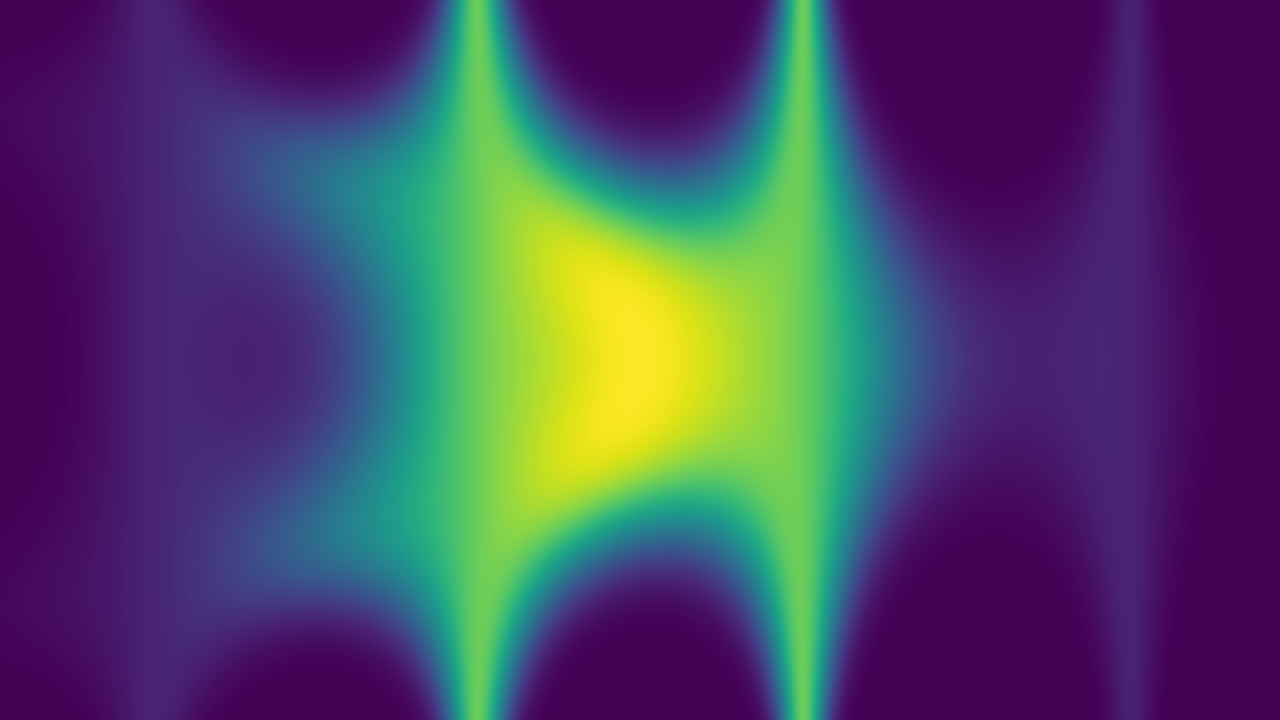

In [6]:
import io
class MyImage(object):
    def __init__(self, data, size=None,
                 fmt='PNG'):
        self.data = data
        if size is None:
            size = data.shape[:2][::-1]  # Images are flipped
        self.size = size
        if fmt == 'PNG':
            self._repr_png_ = self.__repr_png_
        elif fmt == 'JPEG':
            self._repr_jpeg_ = self.__repr_jpeg_
        
    @property
    def _metadata(self):
        return dict(width=f"{self.size[0]:d}px", 
                    height=f"{self.size[1]:d}px")
    
    def __repr_png_(self):
        b = io.BytesIO()
        img = Image.fromarray(self.data)
        img = img.resize(self.size)
        img.save(b, 'PNG')
        return (b.getvalue(), self._metadata)
    def __repr_jpeg_(self):
        """JPEG formatter, but discards alpha"""
        b = io.BytesIO()
        img = Image.fromarray(self.data[..., :3])
        #img = img.resize(self.size)
        img.save(b, 'JPEG')
        return (b.getvalue(), self._metadata)
MyImage(data_to_rgba(get_data()))

Converting to PNG is too slow, converting to JPEG is marginally acceptable.

### Output

Here we use the `Output` widget to capture the results of display.  This provides a marginally acceptable solution with a reasonable ~10fps framerate.

In [7]:
import time
import ipywidgets
from ipywidgets import interact
from super_hydro.contexts import NoInterrupt
from IPython.display import display, clear_output
from PIL import Image
#frame = ipywidgets.
#out = ipywidgets.Output(layout=dict(width=f'{Nxy[0]}px', 
#                                    height=f'{Nxy[1]+100}px'))
out = ipywidgets.Output()
inp = ipywidgets.IntSlider()
msg = ipywidgets.Label()
wid = ipywidgets.VBox([inp, out, msg])
display(wid)
tic = time.time()
toc = 0
frame = 0
data = get_data()
with out:
    with NoInterrupt() as interrupted:        
        while not interrupted:
            data = data_to_rgba(get_data())
            #img = Image.fromarray(data[..., :3])
            myimg = MyImage(data, fmt='JPEG')#, size=(256,)*2)
            display(myimg)
            # The Output() widget allows you to print, but it is slightly
            # faster to use a pre-defined Label()
            # print(f"{frame/(toc-tic):.2f}fps")
            msg.value = f"{frame/(toc-tic):.2f}fps"
            toc = time.time()
            frame += 1
            clear_output(wait=True)

This is a working demonstration with marginal performance characteristics.

### Image

Here we try using the `Image` widget.

In [8]:
import time
import ipywidgets
from ipywidgets import interact
from super_hydro.contexts import NoInterrupt
from IPython.display import display, clear_output
from PIL import Image
img = ipywidgets.Image(format='jpeg')#, width=2*256)
inp = ipywidgets.IntSlider()
msg = ipywidgets.Label()
wid = ipywidgets.VBox([inp, img, msg])
display(wid)
tic = time.time()
toc = 0
frame = 0
data = get_data()
with NoInterrupt() as interrupted:        
     while not interrupted:
        data = data_to_rgba(get_data())
        #img = Image.fromarray(data[..., :3])
        img.value = MyImage(data, fmt='JPEG')._MyImage__repr_jpeg_()[0]
        #display(myimg)
        msg.value = "{:.2f}fps".format(frame/(toc-tic))
        toc = time.time()
        frame += 1
        # clear_output(wait=True)

KeyboardInterrupt: 

# HTML5 Canvas

Here are some references:

* [Is `putImageData` faster than `drawImage`?](https://stackoverflow.com/questions/7721898/is-putimagedata-faster-than-drawimage)

In [9]:
%%html
<style type="text/css">
    canvas {
        border: 1px solid black;
    }
</style>
<canvas></canvas>

In [10]:
from traitlets import Unicode, Bool, validate, TraitError, Instance, Int, Bytes
from ipywidgets import DOMWidget, register
from ipywidgets.widgets.trait_types import bytes_serialization


@register
class Canvas(DOMWidget):
    _view_name = Unicode('CanvasView').tag(sync=True)
    _view_module = Unicode('canvas_widget').tag(sync=True)
    _view_module_version = Unicode('0.1.0').tag(sync=True)
 
    _rgba_data = Bytes(help="RGBA image data").tag(sync=True, **bytes_serialization)
    _image_width = Int(help="Image width").tag(sync=True)
    _image_height = Int(help="Image height").tag(sync=True)

    # Attributes
    width = Int(100, help="Width of canvas").tag(sync=True)
    height = Int(200, help="Height of canvas").tag(sync=True)
    
    @property
    def data(self):
        return self._data

    @data.setter
    def data(self, data):
        self._data = data
        #self._compressed_data = rgba_to_jpeg(data_to_rgba(data))
        self._image_width, self._image_height = data.shape[:2]
        self._rgba_data = data_to_rgba(data).tobytes()

In [11]:
%%javascript
require.undef('canvas_widget');

define('canvas_widget', ["@jupyter-widgets/base"], function(widgets) {
    
    var CanvasView = widgets.DOMWidgetView.extend({

        // Render the view.
        render: function() {
            this.canvas = document.createElement("canvas");
            this.ctx = this.canvas.getContext('2d');
            this.canvas.width = this.model.get('width');
            this.canvas.height = this.model.get('height');
            this.el.appendChild(this.canvas);
            this.update()

            // Python -> JavaScript update
            this.model.on('change:width', this.update, this);
            this.model.on('change:height', this.update, this);
            this.model.on('change:value', this.update, this);
            
            // JavaScript -> Python update
            //this.value.onchange = this.value_changed.bind(this);
        },

        update: function() {
            var options = {'type': 'image/jpeg'};
            var _data = this.model.get('_rgba_data')
            var _raw_data = new Uint8ClampedArray(_data.buffer);
            var _width = this.model.get('_image_width');
            //debugger;
            this._image = new ImageData(_raw_data, _width);
            requestAnimationFrame(this.draw.bind(this));
            //this.draw();
            //var blob = new Blob([this.model.get('_compressed_data')], options);
            //var promise = createImageBitmap(blob);
            //promise.then(this.draw.bind(this));
        },
        
        draw: function() {
            //debugger;
            var image = this._image;
            this.canvas.width = image.width;
            this.canvas.height = image.height;
            this.ctx.putImageData(image, 0, 0)
            //this.ctx.drawImage(image, 0, 0);            
        }
    });

    return {
        CanvasView: CanvasView
    };
});

<IPython.core.display.Javascript object>

In [12]:
canvas = Canvas(data=get_data())
canvas.data = get_data()
display(canvas)

Canvas()

In [15]:
import time
tic = time.time()
for n in range(10):
    canvas.data = get_data()
10/(time.time() - tic)

19.436268581051337

With this I can get 15+fps on Chrome (but it stalls on Safari).

In [16]:
import mmf_setup.set_path.hgroot
from IPython.display import clear_output
from super_hydro.contexts import NoInterrupt
tic = time.time()
frames = 0
with NoInterrupt() as interrupted:
    while not interrupted:
        canvas.data = get_data()
        frames += 1
        toc = time.time()
        display(frames/(toc-tic))
        clear_output(wait=True)

KeyboardInterrupt: 

## Matplotlib

Here are some miscellaneous Matplotlib tools.  This is too slow.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
ax.axis([0,2*np.pi,-1,1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
display(HTML(ani.to_jshtml()))
plt.close('all')

In [ ]:
play = ipywidgets.Play(
    interval=10,
    value=50,
    min=0,
    max=10000,
    step=1,
    description="Press play",
    show_repeat=False,
    disabled=False
)

def on_change(change):
    print(change)

play.observe(on_change, names="value")

slider = ipywidgets.IntSlider()
ipywidgets.jslink((play, 'value'), (slider, 'value'))
ipywidgets.HBox([play, slider])


In [ ]:
play._playing = False

In [ ]:
import ipywidgets
import time
import numpy as np

play = ipywidgets.Play(
    interval=200,
    value=50,
    min=0,
    max=10,
    step=1,
    description="Press play",
    show_repeat=False,    
    disabled=False
)
wid = ipywidgets.IntSlider()
txt = ipywidgets.Label()
display(ipywidgets.VBox([wid, txt, play]))

def on_value_change(change):
    play.value = play.value % play.max
    wid.value += 1
    txt.value = str(play.value)
import traitlets
play.observe(on_value_change, names="value")

In [ ]:
Image

In [ ]:
Image.fromarray(cm.viridis(np.random.random(Nxy), bytes=True))

In [ ]:
%pylab inline --no-import-all
#%pylab notebook --no-import-all
#%matplotlib ipyml


from matplotlib import cm
Nxy = (1024//2, 1024//2)

np.random.seed(2)
def get_data(Nxy=Nxy):
    """Basic routine done on server to generate view data."""
    psi = np.random.random(Nxy + (2,)).view(dtype=complex).reshape(Nxy)-0.5-0.5j
    n = abs(psi)**2
    array = cm.viridis((n-n.min())/(n.max()-n.min()))
    array *= int(255/array.max())  # normalize V0_values
    data = array.astype(dtype='uint8')
    return data

In [ ]:
%timeit data = get_data()

On my computer, this takes 64ms, meaning we should be able to get a 15fps frame-rate.

In [ ]:
import time
from mmfutils.contexts import NoInterrupt
from IPython.display import display, clear_output
with NoInterrupt() as interrupted:
    fig = plt.figure(figsize=(5, 5))
    img = plt.imshow(get_data())
    fig.canvas.draw()
    tic = time.time()
    toc = 0
    frame = 0
    #display(fig)
    time.sleep(1)
    while not interrupted:
        img.set_data(get_data())
        fig.canvas.draw()
        #print("{:.2f}fps".format(frame/(toc-tic)))
        #clear_output(wait=True)
        toc = time.time()
        frame += 1

In [ ]:
with NoInterrupt() as interrupted:
    tic = time.time()
    toc = 0
    frame = 0
    while not interrupted:
        img.set_data(get_data())
        fig.canvas.draw()
        print("{:.2f}fps".format(frame/(toc-tic)))
        clear_output(wait=True)
        toc = time.time()
        frame += 1

# FFT

## Computing Currents

To compute the flow velocity, we need:

$$
  \newcommand{\I}{\mathrm{i}}
  \DeclareMathOperator{\FT}{FT}
  v_x = \frac{1}{m}\Re\frac{-\I\hbar\nabla_x \psi}{\psi}
      = \frac{\hbar}{m}\Re\frac{\FT^{-1}\Bigl(k_x\FT(\psi)\Bigr)}{\psi}.
$$

We want to compute this in 2D as a complex number, so we really want:

$$
  v = v_x + \I v_y.
$$

In [ ]:
%pylab inline
Nx, Ny = Nxy = (32, 32)
np.random.seed(1)
y = np.random.random((Nx, Ny*2)).view(dtype=complex) - 0.5 - 0.5j
kx, ky = ks = np.fft.fftfreq(Nx)[:, None], np.fft.fftfreq(Ny)[None, :]

def j1(y, ks):
    yt = np.fft.fftn(y)
    return ((np.fft.ifftn(ks[0]*yt)/y).real +
        +1j*(np.fft.ifftn(ks[1]*yt)/y).real)

def j2(y, ks):
    yt = np.fft.fftn(y)
    res = (np.fft.ifftn([ks[0]*yt, ks[1]*yt], 
                        axes=(1,2))/y).real
    return res[0] + 1j*res[1]

np.allclose(j1(y, ks), j2(y, ks))
%timeit j1(y, ks)
%timeit j2(y, ks)

# flask-SocketIO

In [4]:
import json
import numpy as np



np.random.seed(7)

A = get_data()

In [7]:

%timeit L = json.loads(json.dumps(A.tolist()))


1.34 s ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit A.tobytes()

1.24 ms ± 8.05 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


AttributeError: 'bytes' object has no attribute 'tolist'

In [5]:
%timeit np.frombuffer(A.tobytes(), dtype=A.dtype).reshape(Nxy)

776 µs ± 7.91 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
np.frombuffer(A.tobytes(), dtype=A.dtype).reshape(Nxy)

array([[2.33376740e-08, 2.69179903e-08, 3.10119291e-08, ...,
        3.10119291e-08, 2.69179903e-08, 2.33376740e-08],
       [2.17349280e-08, 2.50917090e-08, 2.89334501e-08, ...,
        2.89334501e-08, 2.50917090e-08, 2.17349280e-08],
       [2.02549942e-08, 2.34038997e-08, 2.70109067e-08, ...,
        2.70109067e-08, 2.34038997e-08, 2.02549942e-08],
       ...,
       [2.89147795e-07, 3.29201364e-07, 3.74382951e-07, ...,
        3.74382951e-07, 3.29201364e-07, 2.89147795e-07],
       [3.06469838e-07, 3.48638366e-07, 3.96167046e-07, ...,
        3.96167046e-07, 3.48638366e-07, 3.06469838e-07],
       [3.24978044e-07, 3.69389606e-07, 4.19405488e-07, ...,
        4.19405488e-07, 3.69389606e-07, 3.24978044e-07]])

In [ ]:
%%html
<div id="data"></div><br>

<script type="text/javascript" src="{{ url_for('static', filename='js/app_func.js') }}"></script>

In [ ]:
from flask import Flask
from flask_socketio import SocketIO, emit

app = Flask("perf_test")
socketio = SocketIO(app)

@socketio.on('testing')
def testing(msg):
    

In [ ]:
%%javascript
namespace